<a href="https://colab.research.google.com/github/eldusastig/EMTECH-2/blob/main/Assignment_10_2_ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name: Jethro B Duque**

**Course and Section: CPE32S9**

In [7]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot


# Visualize the time series


<ipython-input-2-3334fdc1dc34>:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  series = pd.read_csv('https://raw.githubusercontent.com/eldusastig/EMTECH-2/main/Dataset/data%20(1).csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


            CO2 (ppm)
Month                
1965-01-01     319.32
1965-02-01     320.36
1965-03-01     320.82
1965-04-01     322.06
1965-05-01     322.17


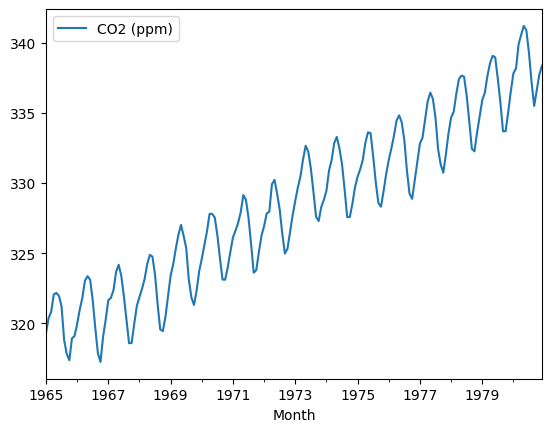

In [ ]:
def parser(x):
	return datetime.strptime(x,'%Y-%m')

series = pd.read_csv('https://raw.githubusercontent.com/eldusastig/EMTECH-2/main/Dataset/data%20(1).csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

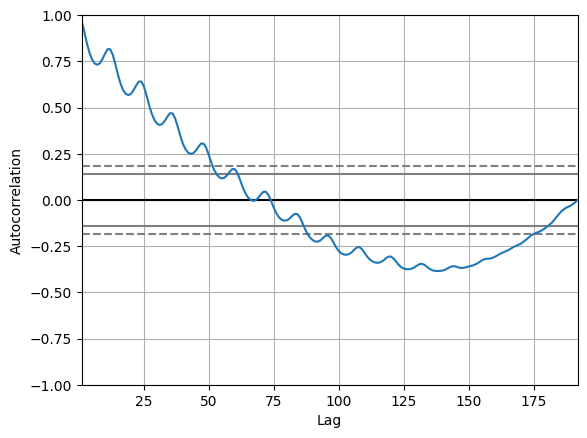

In [ ]:
autocorrelation_plot(series)
pyplot.show()

# Fit an ARIMA Model (baseline model order = (1,1,1))


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

In [ ]:
series.index=series.index.to_period('M')
model = ARIMA(series, order=(1,1,1))
model_fit = model.fit()

In [ ]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                  192
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -225.819
Date:                Fri, 03 May 2024   AIC                            457.638
Time:                        10:25:28   BIC                            467.395
Sample:                    01-31-1965   HQIC                           461.590
                         - 12-31-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5590      0.087      6.441      0.000       0.389       0.729
ma.L1          0.3307      0.092      3.613      0.000       0.151       0.510
sigma2         0.6202      0.071      8.704      0.0

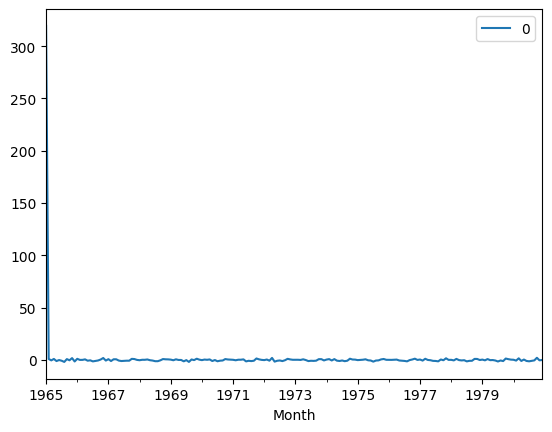

In [ ]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

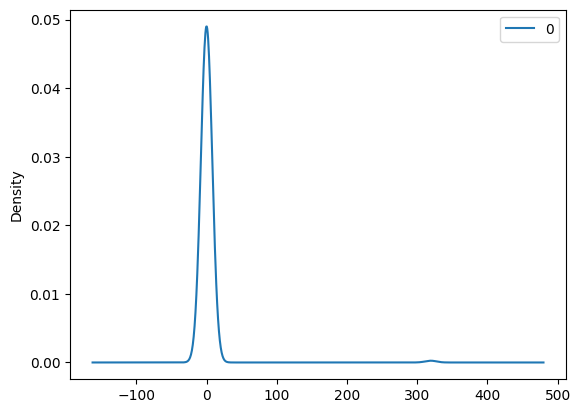

In [ ]:
residuals.plot(kind='kde')
pyplot.show()

# Improve the ARIMA Model


In [ ]:
model = ARIMA(series, order=(6,1,1))
model_fit = model.fit()

# Print the model summary


In [ ]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                  192
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -162.879
Date:                Fri, 03 May 2024   AIC                            341.759
Time:                        10:25:30   BIC                            367.777
Sample:                    01-31-1965   HQIC                           352.298
                         - 12-31-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1725      0.100     11.731      0.000       0.977       1.368
ar.L2         -0.4583      0.137     -3.348      0.001      -0.727      -0.190
ar.L3         -0.4185      0.120     -3.496      0.0

# Make a forecast (steps=10)


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.ticker as ticker


In [ ]:
train_size = int(len(series) * 0.75)
train_data, test_data = series[0:train_size], series[train_size:]

start = len(train_data)
end=len(train_data)+len(test_data)-1
model = ARIMA(train_data, order = (6,1,1))
results = model.fit()
predictions = results.predict(start=start, end=end, dynamic=False, type='levels')
forecast = results.predict(len(series), len(series)+10, typ = 'levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


#Plot the forecast


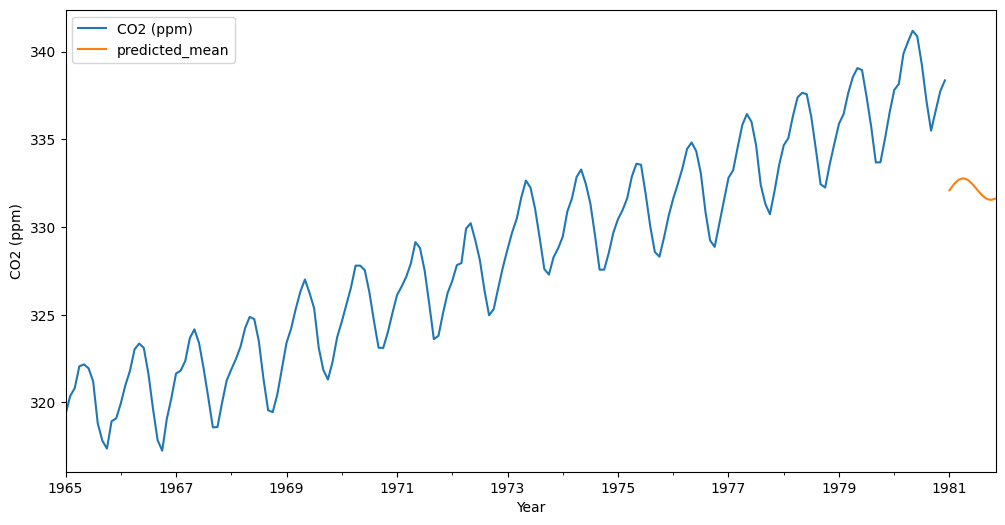

In [ ]:
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ylabel='CO2 (ppm)'
xlabel='Year'

ax = series.plot(legend=True,figsize=(12,6))
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Perform a grid search


In [ ]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
def evaluate_arima_model(X, arima_order):
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	error = mean_squared_error(test, predictions)
	return error
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=70.145
ARIMA(0, 0, 1) RMSE=18.573
ARIMA(0, 0, 2) RMSE=6.819
ARIMA(0, 1, 0) RMSE=1.488
ARIMA(0, 1, 1) RMSE=0.811
ARIMA(0, 1, 2) RMSE=0.573
ARIMA(0, 2, 0) RMSE=0.874
ARIMA(0, 2, 1) RMSE=0.811
ARIMA(0, 2, 2) RMSE=0.772
ARIMA(1, 0, 0) RMSE=1.527
ARIMA(1, 0, 1) RMSE=0.834
ARIMA(1, 0, 2) RMSE=0.595
ARIMA(1, 1, 0) RMSE=0.751
ARIMA(1, 1, 1) RMSE=0.653
ARIMA(1, 1, 2) RMSE=0.551
ARIMA(1, 2, 0) RMSE=0.807
ARIMA(1, 2, 1) RMSE=0.807
ARIMA(1, 2, 2) RMSE=0.656
ARIMA(2, 0, 0) RMSE=0.794
ARIMA(2, 0, 1) RMSE=0.689
ARIMA(2, 0, 2) RMSE=0.585
ARIMA(2, 1, 0) RMSE=0.556
ARIMA(2, 1, 1) RMSE=0.438
ARIMA(2, 1, 2) RMSE=0.443
ARIMA(2, 2, 0) RMSE=0.805
ARIMA(2, 2, 1) RMSE=0.564
ARIMA(2, 2, 2) RMSE=0.556
ARIMA(4, 0, 0) RMSE=0.512
ARIMA(4, 0, 1) RMSE=0.449
ARIMA(4, 0, 2) RMSE=0.424
ARIMA(4, 1, 0) RMSE=0.499
ARIMA(4, 2, 0) RMSE=0.664
ARIMA(4, 2, 1) RMSE=0.624
ARIMA(4, 2, 2) RMSE=0.535
ARIMA(6, 0, 0) RMSE=0.503
ARIMA(6, 0, 1) RMSE=0.520
ARIMA(6, 1, 0) RMSE=0.372
ARIMA(6, 1, 1) RMSE=0.311
ARIMA(6, 1

# Supplementary

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
data=pd.read_csv('https://raw.githubusercontent.com/eldusastig/EMTECH-2/main/Dataset/dataset_temperature.csv',index_col='Month'   ,parse_dates=True)
data=data.dropna()
data = data.drop(data.tail(1).index)



In [3]:
print('Shape of data',data.shape)
data.head()
data

Shape of data (792, 1)


,Mean monthly temperature
Month,
1907-01,33.3
1907-02,46
1907-03,43
1907-04,55
1907-05,51.8
...,...
1972-08,75.6
1972-09,64.1
1972-10,51.7


In [4]:
data['Mean monthly temperature'] = pd.to_numeric(data['Mean monthly temperature'])


<Axes: xlabel='Month'>

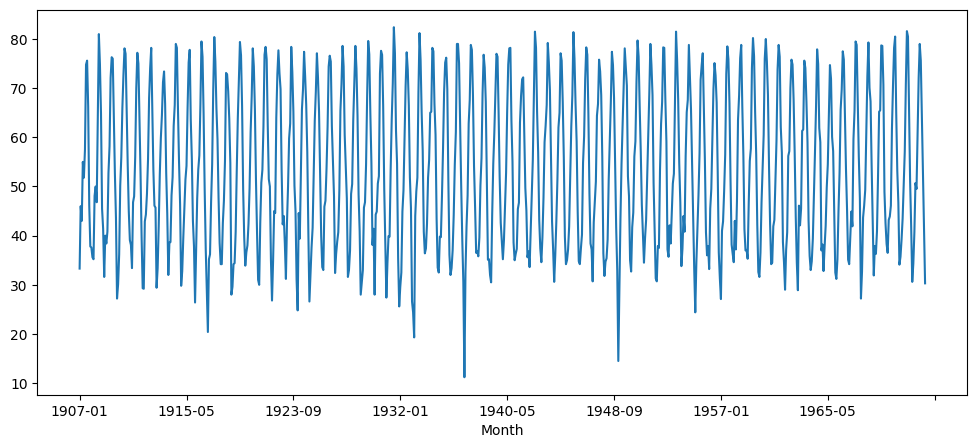

In [ ]:
data['Mean monthly temperature'].plot(figsize=(12,5))


In [ ]:

model = ARIMA(data, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Mean monthly temperature   No. Observations:                  792
Model:                       ARIMA(1, 1, 1)   Log Likelihood               -2773.596
Date:                      Fri, 03 May 2024   AIC                           5553.192
Time:                              11:44:27   BIC                           5567.212
Sample:                          01-01-1907   HQIC                          5558.581
                               - 12-01-1972                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5458      0.060      9.104      0.000       0.428       0.663
ma.L1         -0.0333      0.072     -0.462      0.644      -0.174       0.108
sigm

In [ ]:

model2 = ARIMA(data, order=(50,2,0))
model_fit2 = model2.fit()
print(model_fit2.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Mean monthly temperature   No. Observations:                  792
Model:                      ARIMA(50, 2, 0)   Log Likelihood               -2192.051
Date:                      Fri, 03 May 2024   AIC                           4486.102
Time:                              11:55:54   BIC                           4724.375
Sample:                          01-01-1907   HQIC                          4577.690
                               - 12-01-1972                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7181      0.039    -43.976      0.000      -1.795      -1.642
ar.L2         -2.3750      0.076    -31.374      0.000      -2.523      -2.227
ar.L

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.ticker as ticker
from statsmodels.tsa.arima.model import ARIMA

data['Mean monthly temperature'] = pd.to_numeric(data['Mean monthly temperature'])

train_size = int(len(data) * 0.75)
train_data, test_data = data[0:train_size], data[train_size:]

start = len(train_data)
end = len(train_data) + len(test_data) - 1

model = ARIMA(train_data['Mean monthly temperature'], order=(50, 2, 0))
results = model.fit()

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
forecast = results.predict(len(data), len(data) + 10, typ='levels')

formatter = ticker.StrMethodFormatter('{x:,.0f}')
ylabel = 'Mean Average temperature'
xlabel = 'Year'


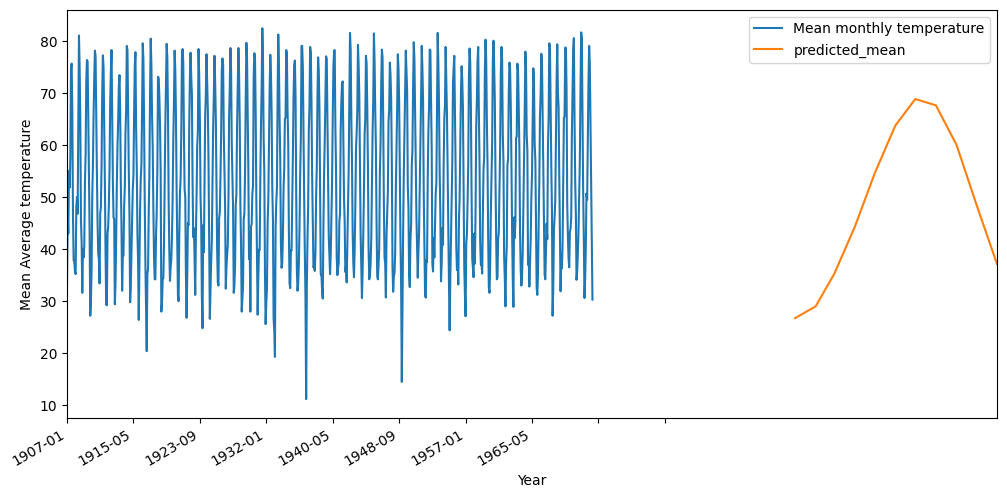

In [ ]:
ax = data.plot(legend=True,figsize=(12,6))
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [5]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error

In [6]:
def evaluate_arima_model(X, arima_order):
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	error = mean_squared_error(test, predictions)
	return error
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

p_values = [0, 2, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=244.071
ARIMA(0, 0, 1) RMSE=104.668
ARIMA(0, 0, 2) RMSE=69.392
ARIMA(0, 1, 0) RMSE=86.206
ARIMA(0, 1, 1) RMSE=68.479
ARIMA(0, 1, 2) RMSE=61.752
ARIMA(0, 2, 0) RMSE=80.907
ARIMA(0, 2, 1) RMSE=76.168
ARIMA(0, 2, 2) RMSE=74.546
ARIMA(2, 0, 0) RMSE=42.500
ARIMA(2, 0, 1) RMSE=24.004
ARIMA(2, 1, 0) RMSE=61.959
ARIMA(2, 1, 1) RMSE=61.436
ARIMA(2, 1, 2) RMSE=24.336
ARIMA(2, 2, 0) RMSE=75.151
ARIMA(2, 2, 1) RMSE=63.805
ARIMA(2, 2, 2) RMSE=73.622
ARIMA(5, 0, 0) RMSE=24.288
ARIMA(5, 0, 1) RMSE=21.000
ARIMA(5, 0, 2) RMSE=15.584
ARIMA(5, 1, 0) RMSE=41.594
ARIMA(5, 1, 1) RMSE=24.319
ARIMA(5, 1, 2) RMSE=22.811
ARIMA(5, 2, 0) RMSE=67.725
ARIMA(5, 2, 1) RMSE=41.659
Best ARIMA(5, 0, 2) RMSE=15.584


In [28]:
X = data.values
size = int(len(X) * 0.66)
test_size=int(len(X) * 0.05)
train, test = X[0:size], X[size:size+test_size]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=75.809544, expected=79.700000
predicted=75.704163, expected=76.400000
predicted=65.084924, expected=66.200000
predicted=52.513977, expected=57.100000
predicted=44.013631, expected=46.300000
predicted=36.079767, expected=40.400000
predicted=32.749907, expected=34.500000
predicted=34.675289, expected=39.500000
predicted=42.028379, expected=43.200000
predicted=52.116868, expected=51.700000
predicted=59.966467, expected=60.700000
predicted=67.930834, expected=69.000000
predicted=72.330956, expected=79.000000
predicted=72.961702, expected=74.700000
predicted=64.542160, expected=68.600000
predicted=55.814677, expected=50.700000
predicted=43.218841, expected=41.300000
predicted=36.502571, expected=31.300000
predicted=32.937558, expected=30.700000
predicted=35.958077, expected=37.900000
predicted=43.298397, expected=37.500000
predicted=49.427690, expected=53.300000
predicted=64.149397, expected=62.700000
predicted=72.950501, expected=67.200000
predicted=72.095475, expected=78.300000


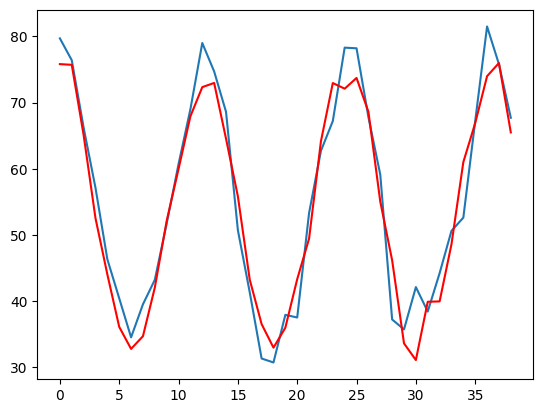

In [30]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.ticker as ticker
from statsmodels.tsa.arima.model import ARIMA

data['Mean monthly temperature'] = pd.to_numeric(data['Mean monthly temperature'])

train_size = int(len(data) * 0.75)
train_data, test_data = data[0:train_size], data[train_size:]

start = len(train_data)
end = len(train_data) + len(test_data) - 1

model = ARIMA(train_data['Mean monthly temperature'], order=(5, 0, 2))
results = model.fit()

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
forecast = results.predict(len(data), len(data) + 10, typ='levels')

formatter = ticker.StrMethodFormatter('{x:,.0f}')
ylabel = 'Mean Average temperature'
xlabel = 'Year'


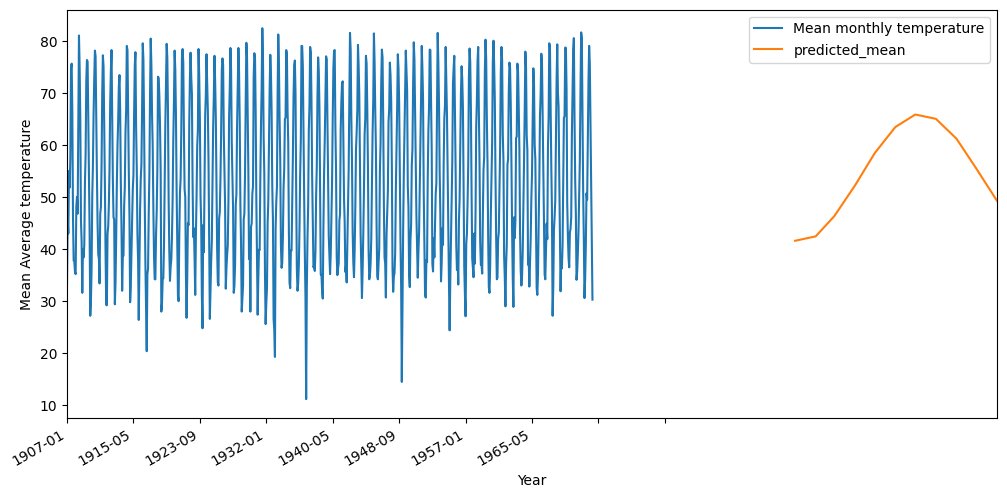

In [32]:
ax = data.plot(legend=True,figsize=(12,6))
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Conclusion

 In this activity I learned how to time series prediction using ARIMA. I learned how we can visualize a time series dataset and how we can use autocorrelation plot to see the relationships of the value. I also learned how we can create an ARIMA model how we visualize and fit this model. I also learning about grid search which useful for optimizing the parameters of an ARIAM model.